In [ ]:
from google.colab import files
import zipfile
from google.colab import drive

import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL.Image import ImageTransformHandler
from skimage import transform as homography_transform
from numpy.linalg import inv
from numpy import random as r
from PIL import Image
from skimage import draw
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow
import copy
from statistics import mean


In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
modelPath = "/content/drive/MyDrive/Senior Design Group 18/modelWithTraining.pt"
testFolder = "/content/drive/MyDrive/Senior Design Group 18/Semantic Seg/Train/"  # Test images

width = 1080
height = 566

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor()])
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))  # final layer of 3 classes (background, table, ball)
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath, map_location=device)) # Load trained model
Net.eval() # Set to evaluation mode
print("Network ready")

ListImages=os.listdir(os.path.join(testFolder, "Image"))
allAnnMaps = []
allSegs = []
plt.rcParams["figure.figsize"] = (20,3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 90.8MB/s]


Network ready


In [ ]:
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor()])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


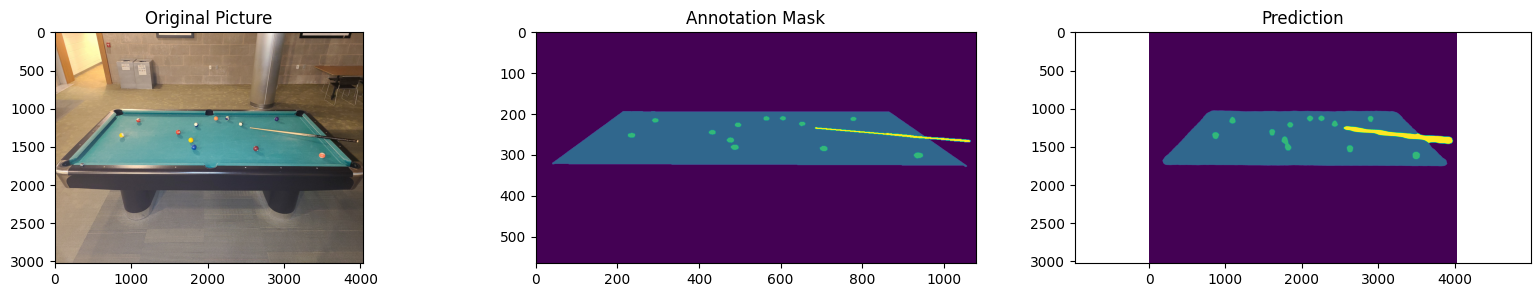

In [ ]:
idx = 3

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
Img=cv2.imread(os.path.join(testFolder, "Image", ListImages[idx]))[:,:,0:3]
height_orgin, widh_orgin, d = Img.shape
Ball =  cv2.imread(os.path.join(testFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
Stick = cv2.imread(os.path.join(testFolder, "Stick", ListImages[idx].replace("jpg","png")),0)
Table =  cv2.imread(os.path.join(testFolder, "Table", ListImages[idx].replace("jpg","png")),0)
AnnMap = np.zeros(Img.shape[0:2],np.float32)
if Table is not None:  AnnMap[ Table > 200 ] = 1
if Ball is not None:  AnnMap[ Ball > 200 ] = 2
if Stick is not None: AnnMap [ Stick > 200 ] = 3
ax1.imshow(Img[:,:,::-1])  # Show image
ax1.set_title("Original Picture")
# plt.show()
Img=transformImg(Img)
AnnMap=transformAnn(AnnMap)
ax2.imshow(AnnMap[0,:,:])
ax2.set_title("Annotation Mask")
allAnnMaps.append(AnnMap[0,:,:])
# plt.show()
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
allSegs.append(seg)
ax3.imshow(seg)  # display image
ax3.set_title("Prediction")
plt.show()

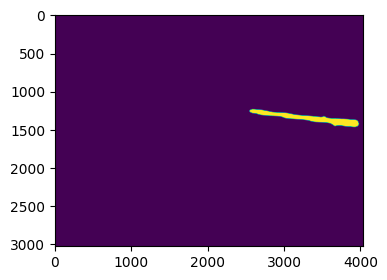

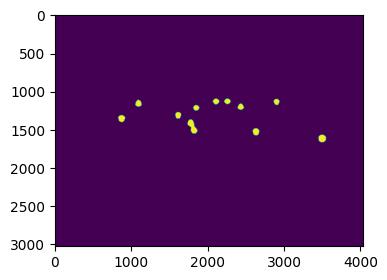

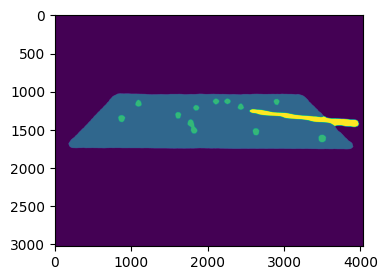

In [ ]:
import torchvision.transforms as transforms


tensorTransform = transforms.ToTensor()
# Convert the image to PyTorch tensor
img = tensorTransform(seg)[0,:,:]
# img = seg
img_stick = copy.deepcopy(img)
img_ball = copy.deepcopy(img)
img_table = copy.deepcopy(img)
img_stick [ img_stick != 3 ] = 0
plt.imshow(img_stick)
plt.show()
img_ball [ img_ball != 2 ] = 0
plt.imshow(img_ball)
plt.show()
# img_table [ img_table != 1] = 0
plt.imshow(img_table)
plt.show()

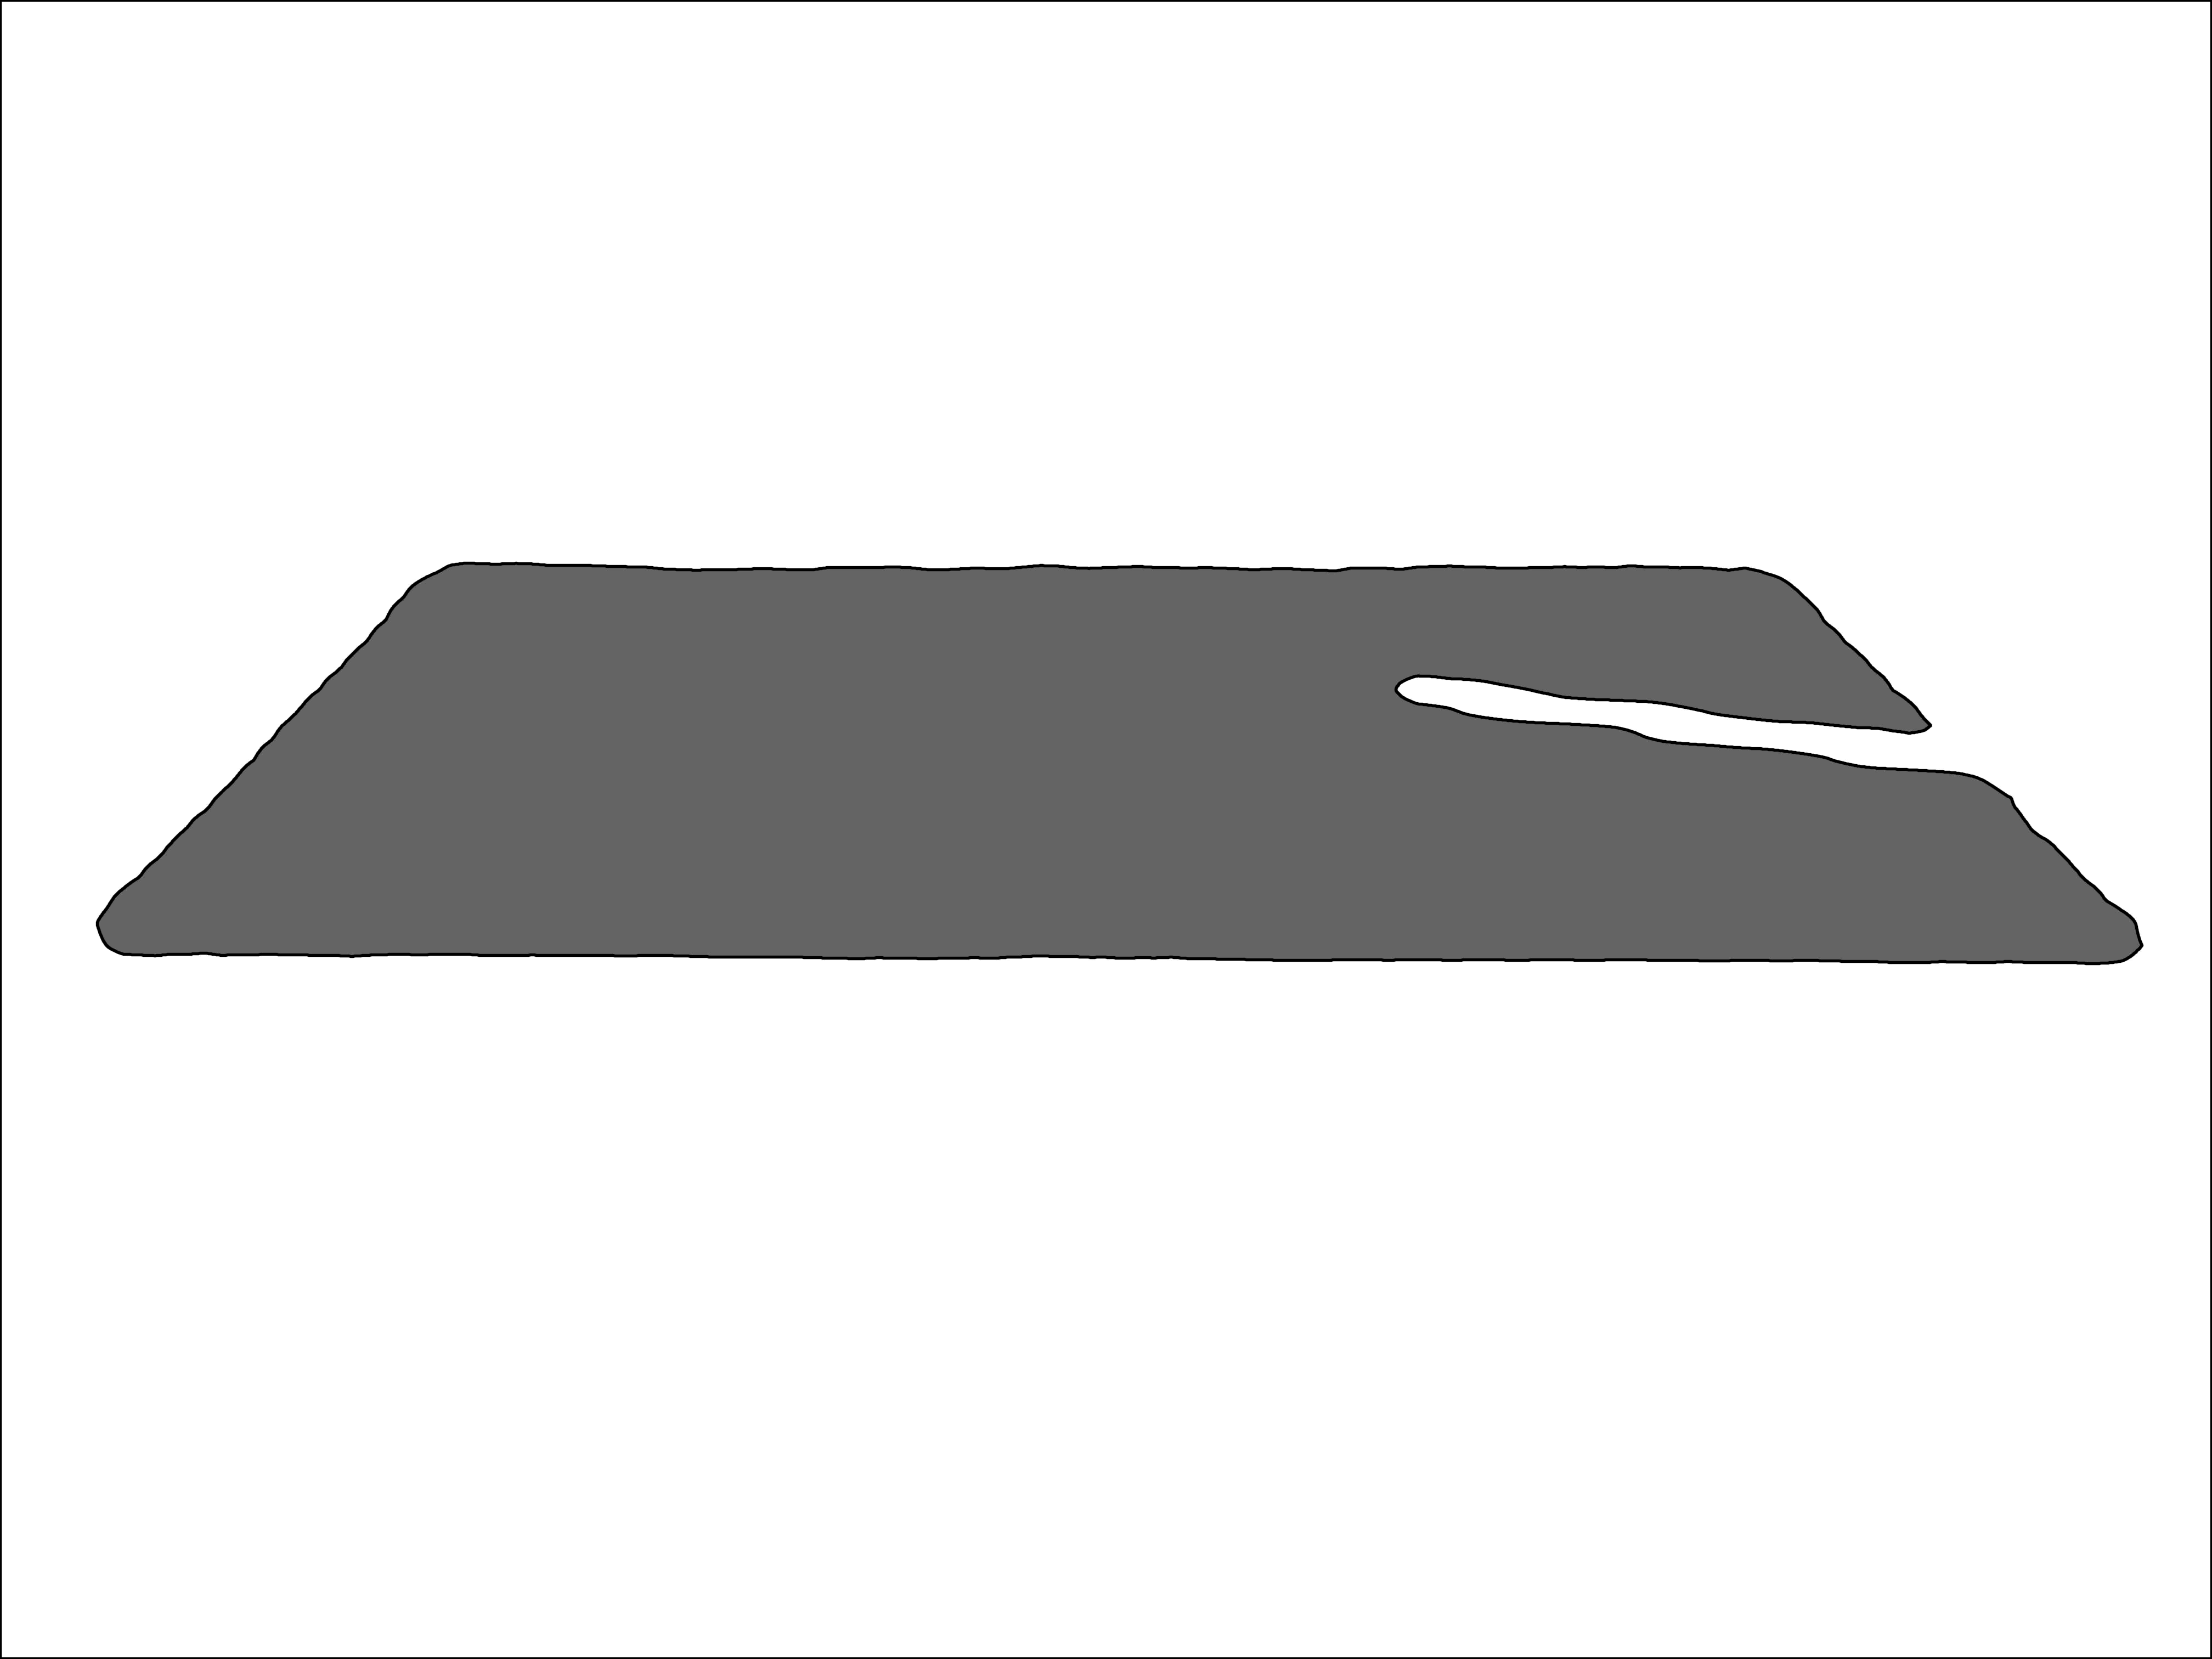

(3024, 4032)


In [ ]:
to_table_dict = {0:255, 1:100, 2:100, 3:255}
mat = np.vectorize(to_table_dict.get)(img_table).astype(float)
im = Image.fromarray(mat)
im.convert('RGB').save('table_mask.jpg')
im = cv2.imread('table_mask.jpg', cv2.IMREAD_GRAYSCALE)
ret, thresh = cv2.threshold(im, 150, 255, cv2.THRESH_BINARY)
# thresh_inverse = cv2.bitwise_not(im)
contours, hierarchy = cv2.findContours(image = thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
cv2.drawContours(image=im, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
cv2_imshow(im)
print(im.shape)

In [ ]:
width = 4032
height = 3024 # image width and height
pts = []
for i in range(1, len(contours)):
    pts.extend(np.squeeze(contours[i]))
pts = np.asarray(pts)
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

top_left = pts[closest_node([0, 0], pts)]
bottom_left = pts[closest_node([0, height], pts)]
bottom_right = pts[closest_node([width, height], pts)]
top_right = pts[closest_node([width, 0], pts)]

start_pts = np.array([bottom_left, top_left, top_right, bottom_right])
end_pts = np.array([[100, 2500], [100, 500], [3932, 500], [3932, 2500]])
start_pts

array([[ 224, 1739],
       [ 757, 1063],
       [3259, 1062],
       [3852, 1754]], dtype=int32)

In [ ]:
def homography(img_mask,
               startpts = np.matrix('80 1750; 750 1050; 3200 1050; 3850 1750'),
               endpts = np.array([[0, 2500], [0, 500], [4000, 500], [4000, 2500]]),
               value = 0):
  # np.set_printoptions(precision=3)
  # np.set_printoptions(suppress=True)

  A = np.zeros([8, 9])
  N = startpts.shape[0]
  for i in range(N):
    x, y = startpts[i, 0], startpts[i, 1]
    x_, y_ = endpts[i, 0], endpts[i, 1]
    row0 = np.array([-x, -y, -1, 0, 0, 0, x_*x, x_*y, x_])
    row1 = np.array([0, 0, 0, -x, -y, -1, y_*x, y_*y, y_])
    A[2*i] = row0
    A[2*i+1] = row1
  U, S, V = np.linalg.svd(A)
  q = V[-1].T

  M = q.reshape((3,3))

  warped_img1 = homography_transform.warp(img_mask, inv(M))
  if value != 0: warped_img1[warped_img1 > 0] = value
  warped_img = np.rint(warped_img1).astype(int)
  plt.imshow(warped_img1)
  plt.show()
  return warped_img1

def detect_ball(warped_image):
  to_ball_dict = {0:255, 1:255, 2:1, 3:255}
  mat = np.vectorize(to_ball_dict.get)(warped_image).astype(float)
  mat = gaussian_filter(mat, sigma=40)
  im = Image.fromarray(mat)
  im.convert('RGB').save('ball_blob.jpg')

  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 0
  params.maxThreshold = 256
  params.thresholdStep = 1
  params.filterByArea = True
  params.minArea = 100
  params.filterByCircularity = False
  params.minCircularity = 0.3
  params.filterByConvexity = False
  params.minConvexity = 0.8
  params.filterByInertia = False
  # params.minInertiaRatio = 0
  # params.maxInertiaRatio = 1

  detector = cv2.SimpleBlobDetector_create(params)
  im = cv2.imread('ball_blob.jpg', cv2.IMREAD_GRAYSCALE)

  keypts = detector.detect(im)
  im_with_keypoints = cv2.drawKeypoints(im, keypts, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(im_with_keypoints)
  return keypts, im_with_keypoints

def detect_stick(warped_image):
  to_stick_dict = {0:255, 1:255, 2:255, 3:1}
  mat = np.vectorize(to_stick_dict.get)(warped_image).astype(float)
  mat = gaussian_filter(mat, sigma=0)
  im = Image.fromarray(mat)
  im.convert('RGB').save('stick_blob.jpg')

  params = cv2.SimpleBlobDetector_Params()
  params.minThreshold = 0
  params.maxThreshold = 256
  params.thresholdStep = 1
  params.filterByArea = False
  params.minArea = 100
  params.filterByCircularity = False
  params.minCircularity = 0.3
  params.filterByConvexity = False
  params.minConvexity = 0.8
  params.filterByInertia = False
  # params.minInertiaRatio = 0
  # params.maxInertiaRatio = 1

  detector = cv2.SimpleBlobDetector_create(params)
  im = cv2.imread('stick_blob.jpg', cv2.IMREAD_GRAYSCALE)

  keypts = detector.detect(im)
  im_with_keypoints = cv2.drawKeypoints(im, keypts, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  cv2_imshow(im_with_keypoints)
  return keypts, im_with_keypoints

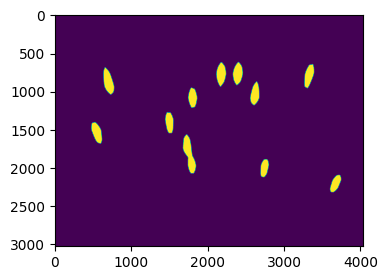

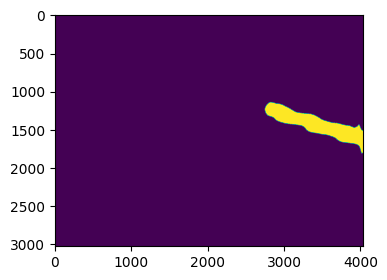

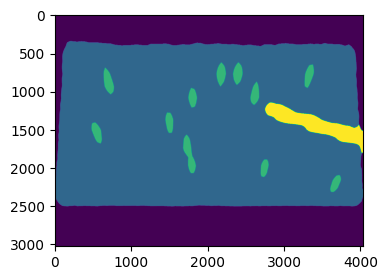

In [ ]:
# print(np.count_nonzero(img_stick == 3))
warped_ball = homography(img_ball, start_pts, end_pts, 2)
warped_stick = homography(img_stick, start_pts, end_pts, 3)
warped_table = homography(img_table, start_pts, end_pts)

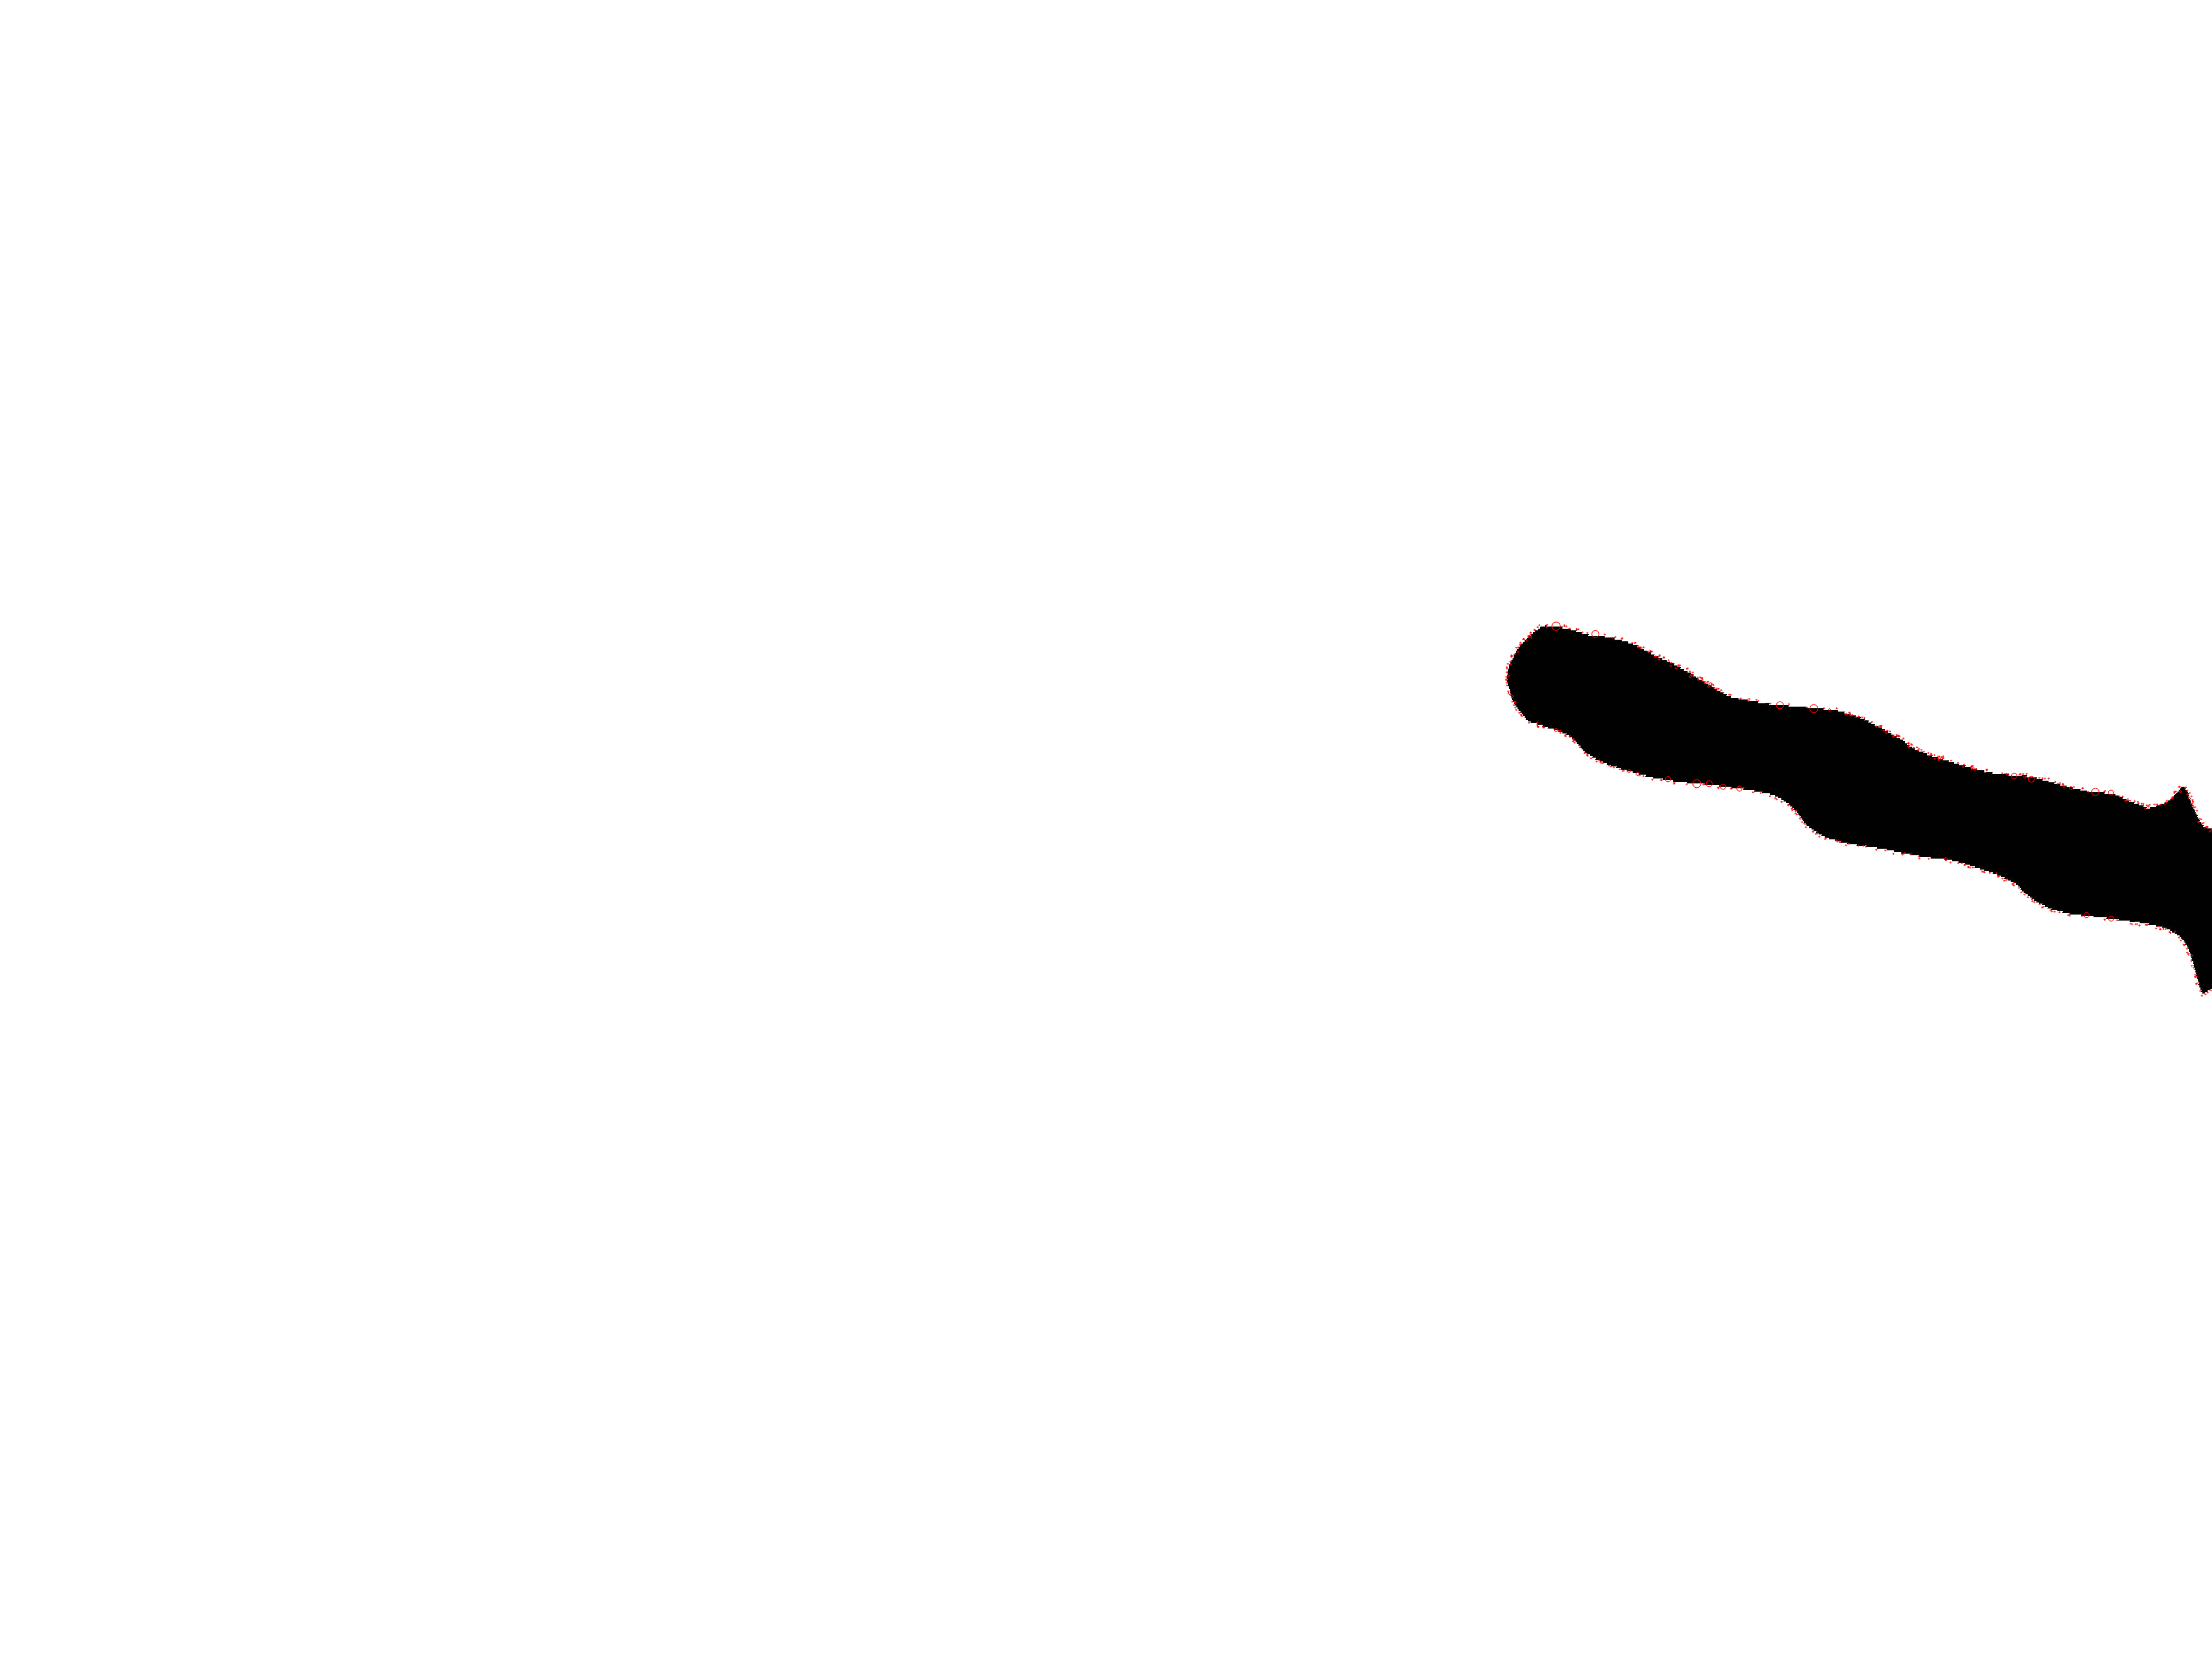

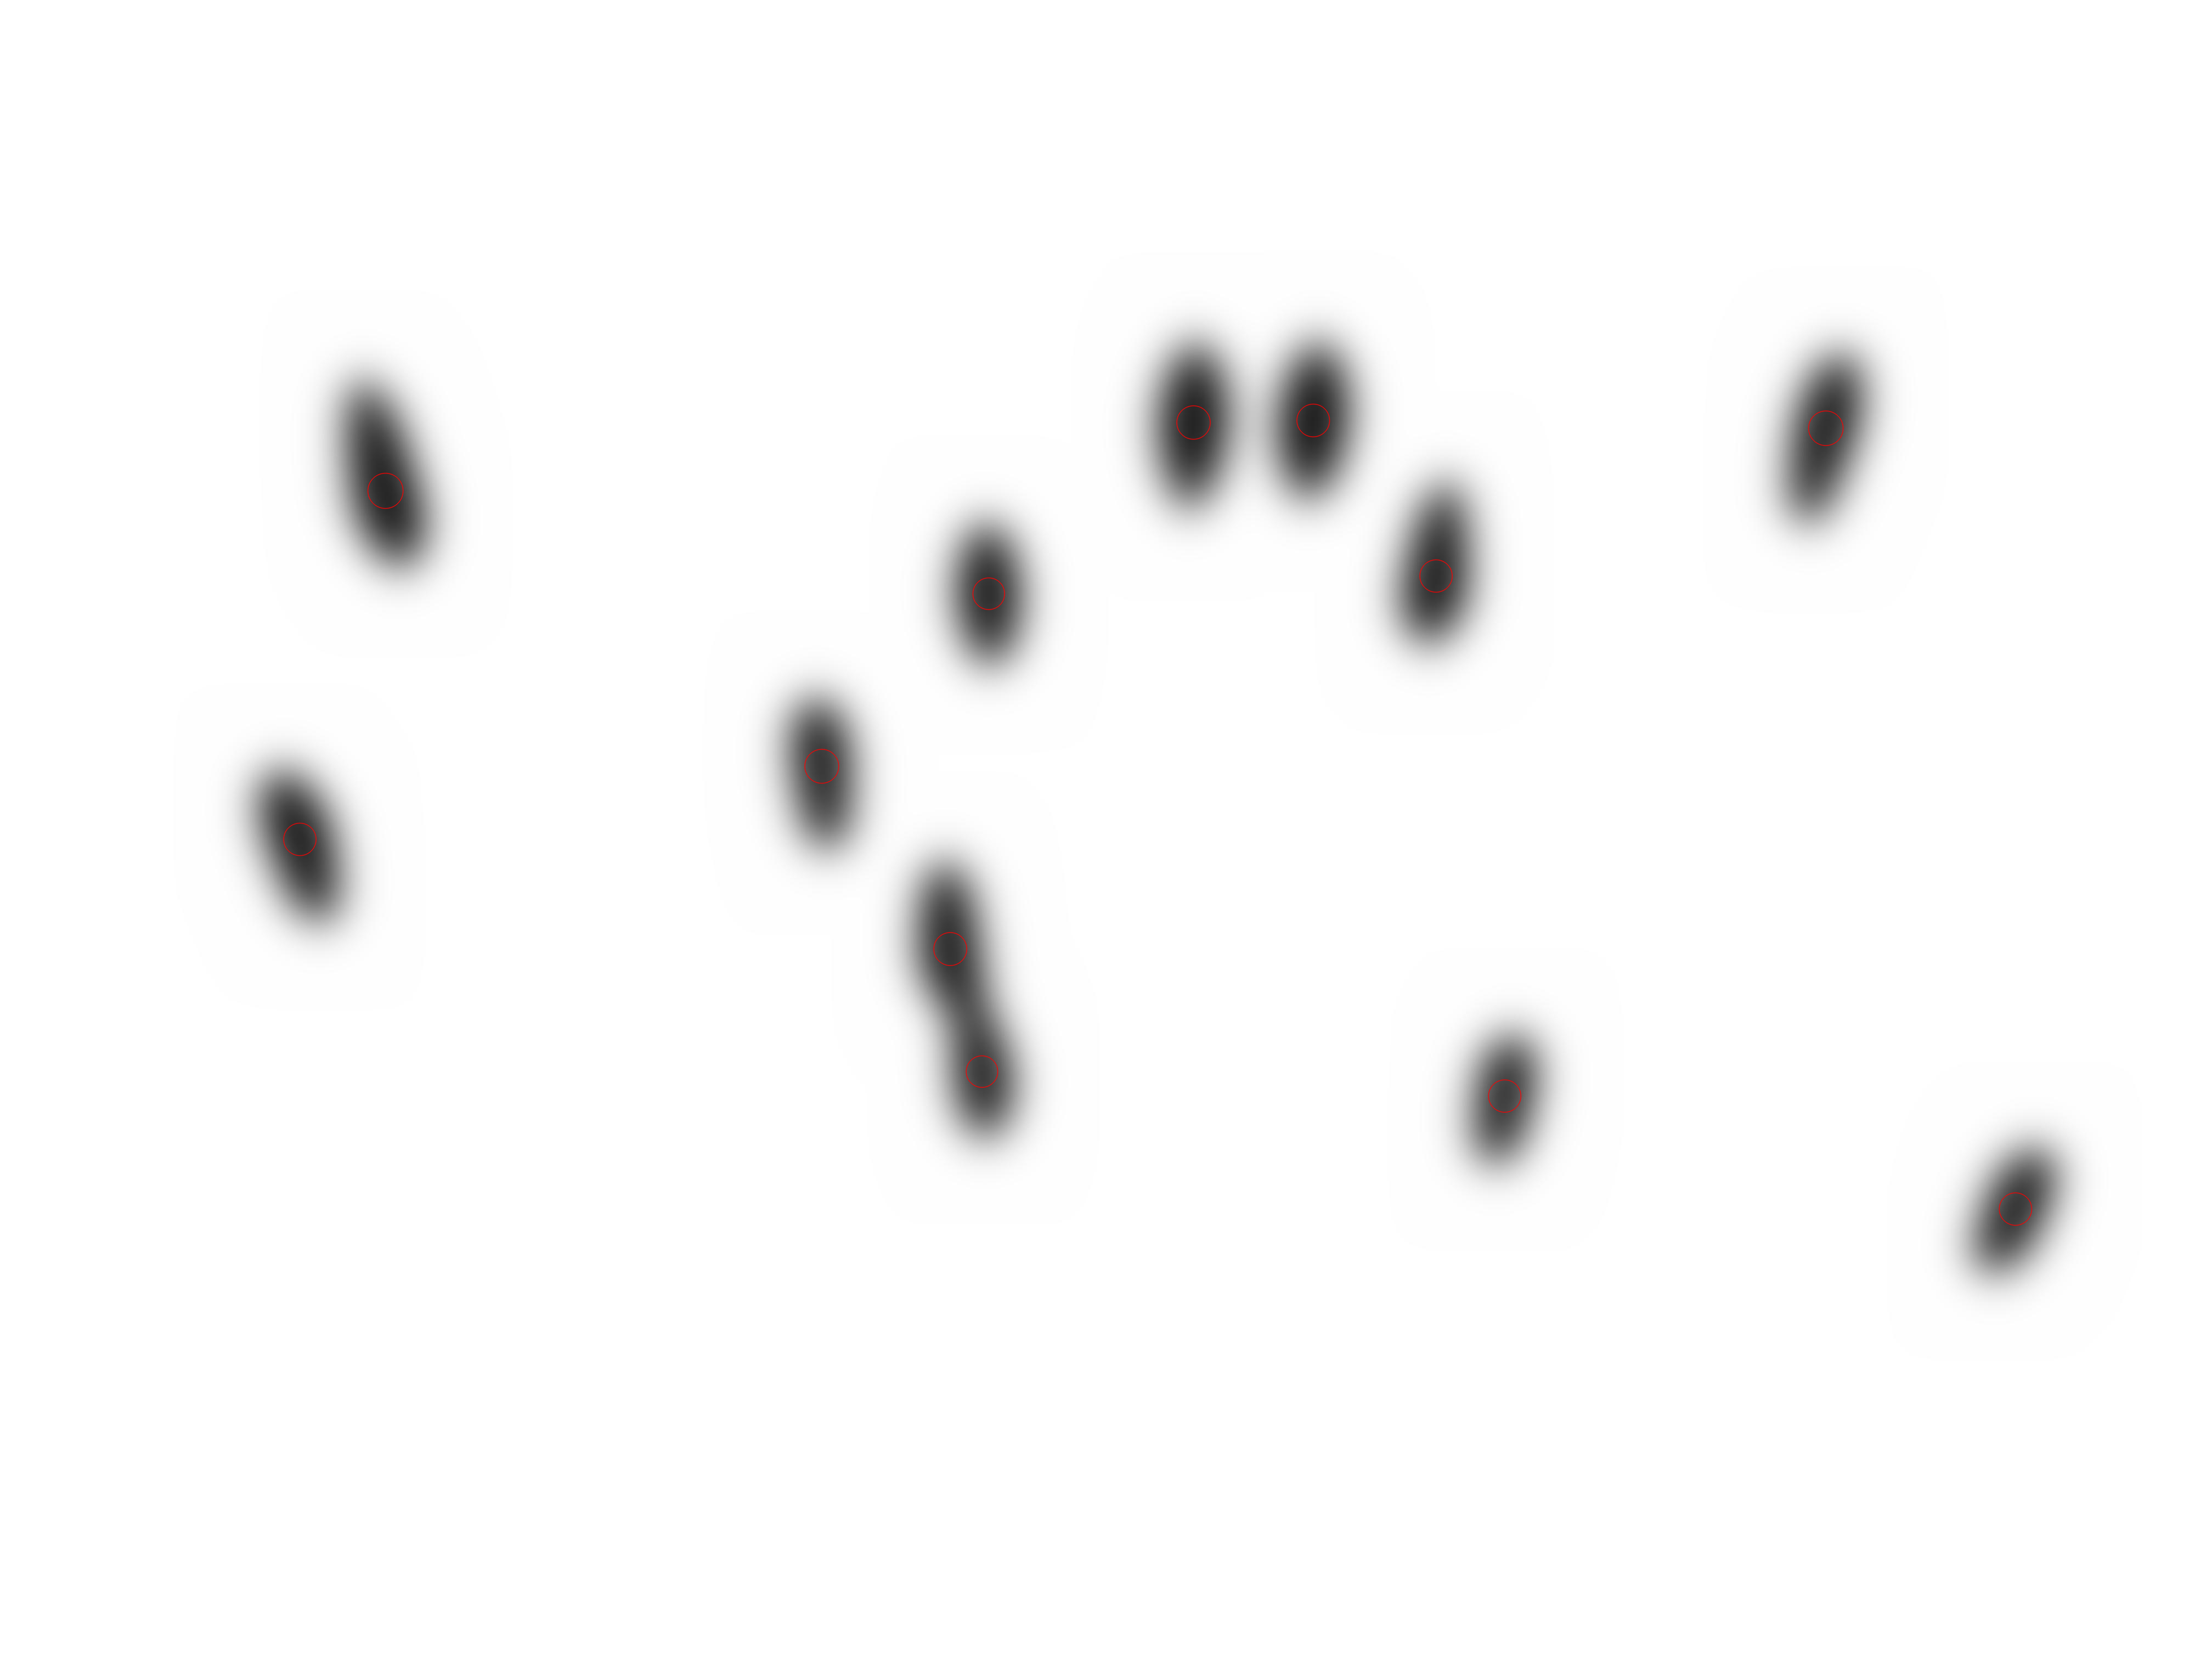

In [ ]:
# print(np.count_nonzero(warped_stick != 0))
stick_keys, stick_with_keypts = detect_stick(warped_stick)
ball_keys, ball_with_keypts = detect_ball(warped_ball)

ball_coords = []
for kpt in ball_keys:
  ball_coords.append(kpt.pt)

stick_pts = []
for kpt in stick_keys:
  stick_pts.append(kpt.pt)

In [ ]:
# CODE to get linear set of points for plotting
# RISHIKA :)
from scipy.special import i1e
def best_fit(stick_pts):
    stick_x = []
    stick_y = []
    for i in stick_pts:
      stick_x.append(i[0])
      stick_y.append(i[1])

    stick_x = np.array(stick_x)
    stick_y = np.array(stick_y)

    m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))
    b = mean(stick_y) - m*mean(stick_x)

    extremepoints = []
    if abs(m) < 1:
      min_x = min(stick_x)
      max_x = max(stick_x)
      extremepoints.append(tuple((min_x, min_x * m + b)))
      extremepoints.append(tuple((max_x, max_x * m + b)))

    else:
      min_y = min(stick_y)
      max_y = max(stick_y)
      extremepoints.append(tuple(((min_y - b) / m, min_y)))
      extremepoints.append(tuple(((max_y - b) / m, max_y)))

    return extremepoints

In [ ]:
def best_fit_extrema(stick_pts):
    stick_x = []
    stick_y = []
    for i in stick_pts:
      stick_x.append(i[0])
      stick_y.append(i[1])

    stick_x = np.array(stick_x)
    stick_y = np.array(stick_y)

    m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))
    b = mean(stick_y) - m*mean(stick_x)

    extremepoints = []
    #print(m)
    if m > 0:
      i1 = np.argmin(stick_x)
      i2 = np.argmax(stick_y)
      j1 = np.argmax(stick_x)
      j2 = np.argmin(stick_y)

    else:
      i1 = np.argmin(stick_x)
      i2 = np.argmin(stick_y)
      j1 = np.argmax(stick_x)
      j2 = np.argmax(stick_y)

    return np.array([tuple((stick_x[i1], stick_y[i1])), tuple((stick_x[i2], stick_y[i2])), tuple((stick_x[j1], stick_y[j1])), tuple((stick_x[j2], stick_y[j2]))])
    # extremepoints.append( tuple((round((stick_x[i1] + stick_x[i2]) / 2) , round((stick_y[i1] + stick_y[i2]) / 2))) )
    # extremepoints.append( tuple((round((stick_x[j1] + stick_x[j2]) / 2) , round((stick_y[j1] + stick_y[j2]) / 2))) )

    # return extremepoints

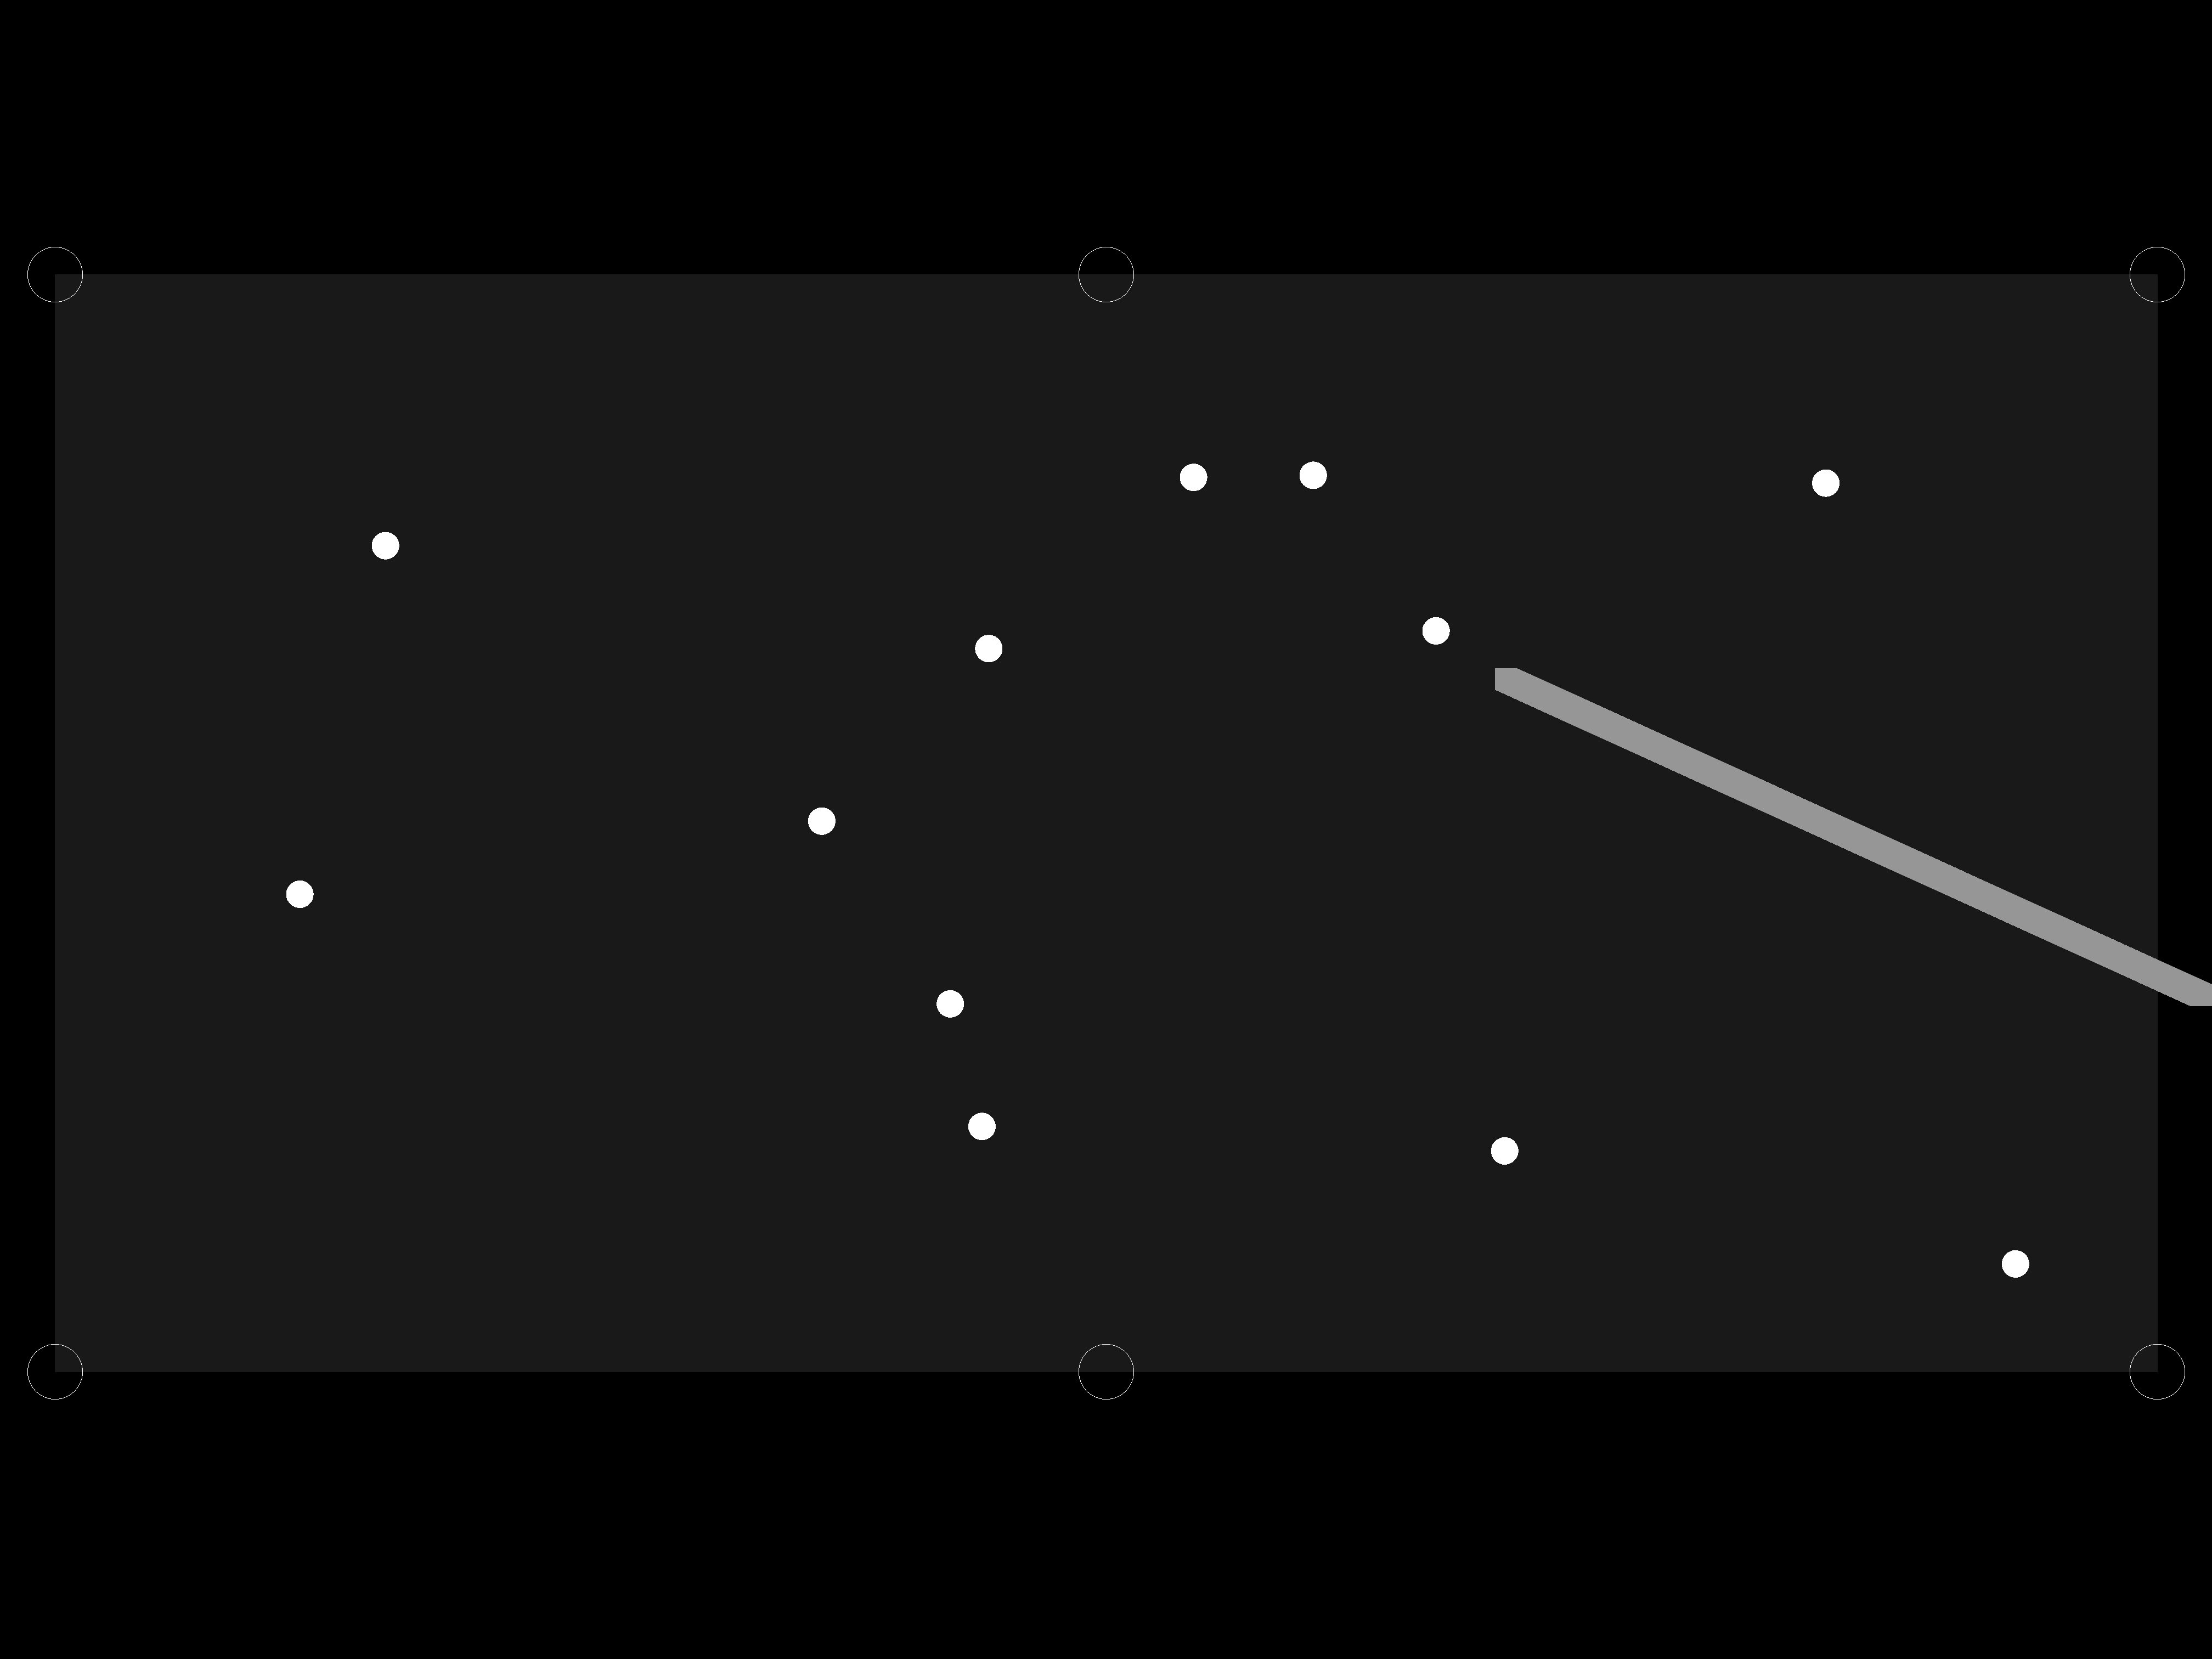

In [ ]:
grid = np.zeros([width, height])

r = end_pts[:,0]
c = end_pts[:,1]
rr, cc = draw.polygon(r, c)
grid[rr, cc] = 25

for pt in ball_coords:
  pt_t = [pt[0], pt[1] + 100] # ball offset 100 pixels
  rr, cc = draw.disk(pt_t, 25, shape=grid.shape)
  grid[rr, cc] = 255


stick_extremes = best_fit_extrema(stick_pts)

rr, cc = draw.line_nd(stick_extremes[0], stick_extremes[1])
grid[rr, cc] = 150
# r = stick_extremes[:,0]
# c = stick_extremes[:,1]
# rr, cc = draw.polygon(r, c)
# grid[rr, cc] = 150
for i in range (-20,20):
  for j in range(-20, 20):
    grid[rr+i, cc+j] = 150

mid_pockets = np.zeros([2, 2])
mid_pockets[0] = (end_pts[0] + end_pts[3]) / 2
mid_pockets[1] = (end_pts[1] + end_pts[2]) / 2
mid_pockets = mid_pockets.round().astype(int)
pockets = np.concatenate((end_pts, mid_pockets), axis=0)

for pocket in pockets:
  rr, cc = draw.circle_perimeter(pocket[0], pocket[1], 50)
  grid[rr, cc] = 255

im = Image.fromarray(grid.transpose())
im.show()

In [ ]:
def cue_stick_extreme_points():
  stick_extremes = best_fit_extrema(stick_pts)
  return stick_extremes

def direction_vector_cue_stick(start_point, end_point):
  direction_vector = np.array(end_point) - np.array(start_point)
  x = direction_vector[0]
  y = direction_vector[1]
  if (abs(x) > abs(y)):
    max_coord = x
  else:
    max_coord = y

  if max_coord == x:
    if x > 0:
      return 'right'
    else:
      return 'left'

  if max_coord == y:
    if y > 0:
      return 'up'
    else:
      return 'down'

  return 'neither'

def determine_trajectory_end_point(direction_vector,m, b):
  if direction_vector == 'down' or direction_vector == 'up':
    if direction_vector == 'down':
      x = (500 - b) / m
      trajectory_end_point = [x, 500]
    else:
      x = (2500 - b) / m
      trajectory_end_point = [x, 2500]

  if direction_vector == 'left' or direction_vector == 'right':
    if direction_vector == 'left':
      y = m * 3932 + b
      trajectory_end_point = [3932, y]
    else:
      y = m * 100 + b
      trajectory_end_point = [100, y]

  return trajectory_end_point

def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    dot_prod = dot(vA, vB)
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    cos_ = dot_prod/magA/magB
    angle = math.acos(dot_prod/magB/magA)
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        return 360 - ang_deg
    else:

        return ang_deg

def determine_length_constant(direction_vector):
  if (direction_vector == 'down' or direction_vector == 'up'):
    return 4
  else:
    return 39

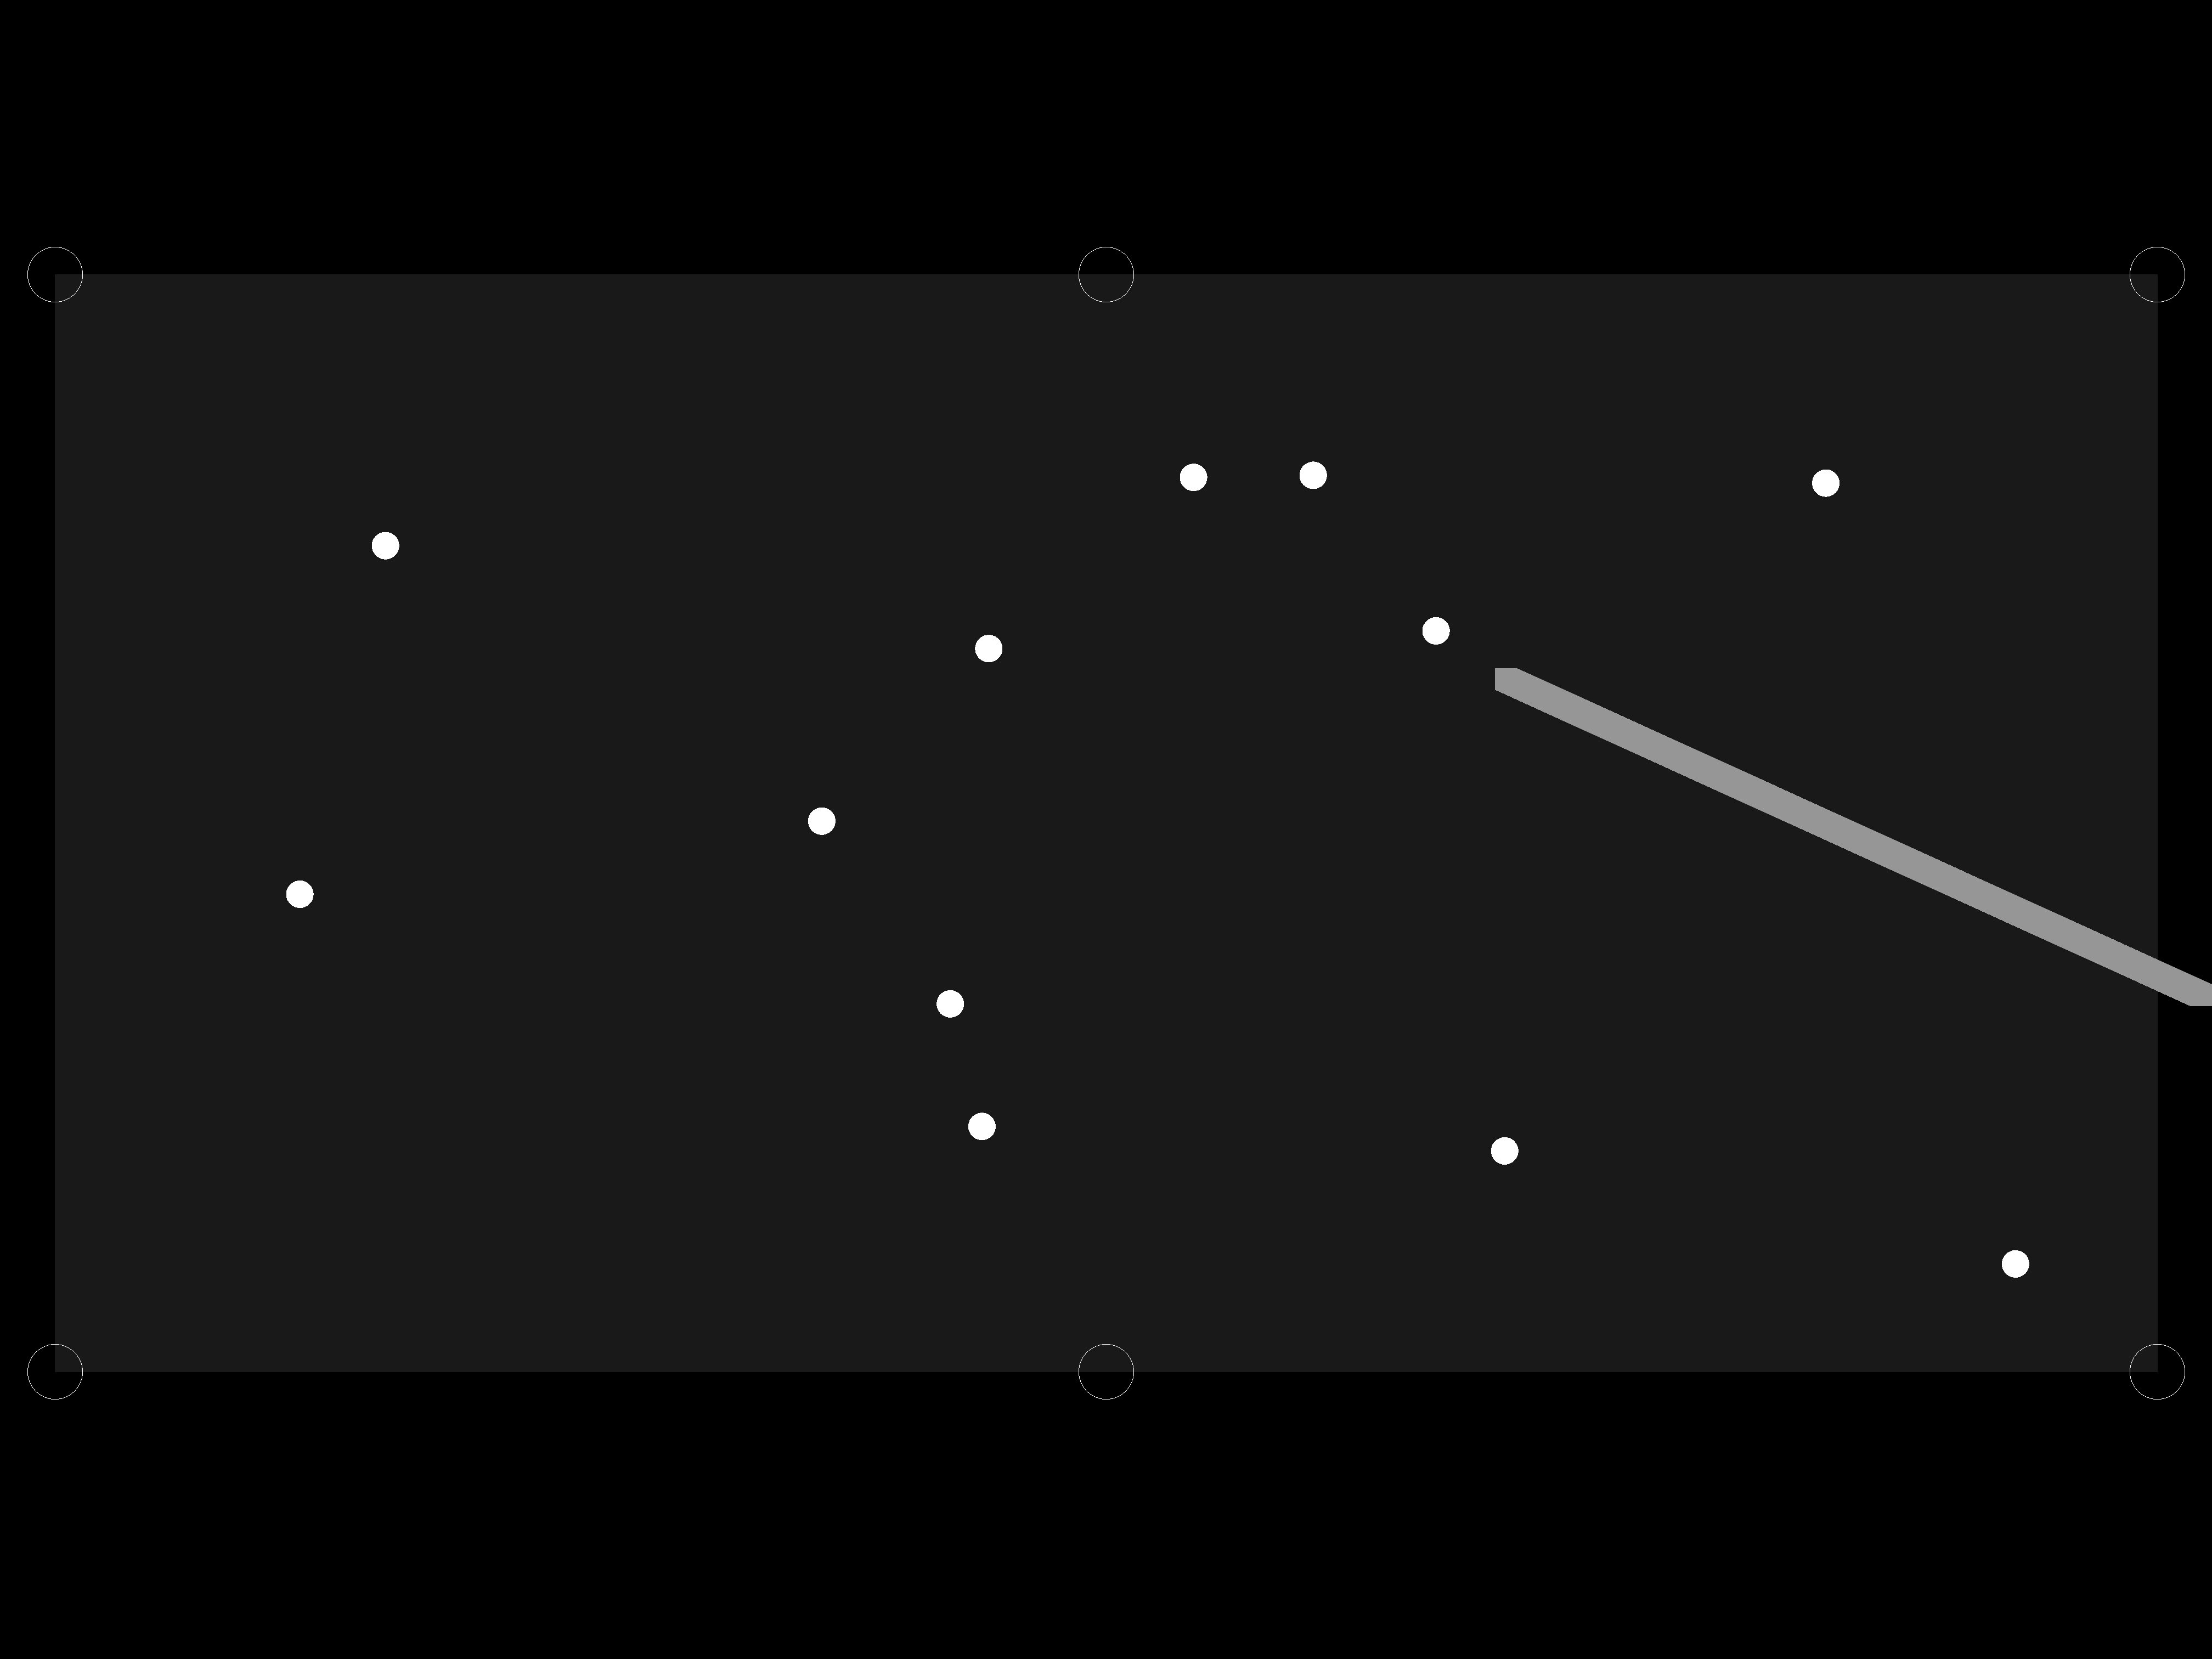

In [ ]:
#show pool table
grid = np.zeros([width, height])

r = end_pts[:,0]
c = end_pts[:,1]
rr, cc = draw.polygon(r, c)
grid[rr, cc] = 25

#show pool balls on the table
for pt in ball_coords:
  pt_t = [pt[0], pt[1] + 100] # ball offset 100 pixels
  rr, cc = draw.disk(pt_t, 25, shape=grid.shape)
  grid[rr, cc] = 255


points = cue_stick_extreme_points()
ball_in_cue_path = []
cue_stick_hit_ball = []
for i in points:
  for j in ball_coords:
    if (j[0] >= (int(i[0]) - 150) and j[0] <= (int(i[0]) + 150)) and (j[1] >= (int(i[1]) - 200) and j[1] <= (int(i[1]) + 200)) and j[0] not in ball_in_cue_path:
      ball_in_cue_path.append(j[0])
      cue_stick_hit_ball.append(i[0])

if (len(ball_in_cue_path) != 0):
  #find trajectory ball point coordinates
  trajectory_ball_point = []
  for el in ball_in_cue_path:
    for el_j in ball_coords:
      if el == el_j[0]:
        trajectory_ball_point.append([el_j[0], el_j[1]])

  #find ball in path coordinates
  ball_in_path = []
  for el in ball_in_cue_path:
    for el_j in ball_coords:
      if(el_j[0] == el):
        ball_in_path.append(el_j)

  #find slope of cue stick
  stick_x = []
  stick_y = []
  for i in stick_pts:
    stick_x.append(i[0])
    stick_y.append(i[1])
  stick_x = np.array(stick_x)
  stick_y = np.array(stick_y)
  m = (((mean(stick_x)*mean(stick_y)) - mean(np.multiply(stick_x,stick_y))) / ((mean(stick_x)*mean(stick_x)) - mean(np.multiply(stick_x,stick_x))))


  #determine direction of cue stick
  direction_vector = direction_vector_cue_stick(stick_extremes[0], stick_extremes[1])
  #find value of b
  b = ball_in_path[0][1] - m * ball_in_path[0][0]

  #get trajectory end points
  trajectory_end_point = determine_trajectory_end_point(direction_vector,m, b)

  #stick extreme points
  stick_extremes = best_fit_extrema(stick_pts)


  #get
  rr, cc = draw.line_nd((trajectory_ball_point[0][0], trajectory_ball_point[0][1] + 100), trajectory_end_point)
  grid[rr, cc] = 150


  # lineA = [(trajectory_end_point[0], trajectory_end_point[1]), (trajectory_ball_point[0][0], trajectory_ball_point[0][1])]
  # lineB = [(trajectory_end_point[0], trajectory_end_point[1]), ((trajectory_end_point[0], trajectory_ball_point[0][1]))]

  # angle = -2 * ang(lineB, lineA)

  # angle_radians = math.radians(angle)

  # start_point = (trajectory_end_point[0], trajectory_end_point[1])

  # start_point2 = (trajectory_end_point[0], trajectory_end_point[1])
  # end_point2 = (trajectory_ball_point[0][0], trajectory_ball_point[0][1])

  # delta_x2 = end_point2[0] - start_point2[0]
  # delta_y2 = end_point2[1] - start_point2[1]
  # length2 = math.sqrt(delta_x2 ** 2 + delta_y2 ** 2)
  # direction_vector2 = (delta_x2 / length2, delta_y2 / length2)

  # direction_vector1 = (math.cos(angle_radians) * direction_vector2[0] - math.sin(angle_radians) * direction_vector2[1],
  #                     -math.sin(angle_radians) * direction_vector2[0] + math.cos(angle_radians) * direction_vector2[1])


  # len_multiply = determine_length_constant(direction_vector)

  # length1 = len_multiply * length2
  # end_point1 = (start_point[0] + length1 * direction_vector1[0],
  #               start_point[1] + length1 * direction_vector1[1])


  # trajectory_slope = (start_point[1] - length1 * direction_vector1[1] - trajectory_end_point[1]) / (start_point[0] + length1 * direction_vector1[0] - trajectory_end_point[0])

  # ball_in_trajectory_path = []
  # for el in ball_coords:
  #     y = el[1]
  #     res_y = trajectory_slope * el[0] + b
  #     if (y == res_y):
  #       ball_in_trajectory_path.append(el)


  # rr, cc = draw.line_nd(trajectory_end_point, (start_point[0] + len_multiply * direction_vector1[0], start_point[1] + len_multiply * direction_vector1[1]))
  # grid[rr, cc] = 150

#   # if len(ball_in_trajectory_path) == 0:
#   #   rr, cc = draw.line_nd(trajectory_end_point, (start_point[0] + length1 * direction_vector1[0], start_point[1] + length1 * direction_vector1[1]))
#   #   grid[rr, cc] = 150
#   # else:
#   #   rr, cc = draw.line_nd(trajectory_end_point, ball_in_trajectory_path[0])
#   #   grid[rr, cc] = 150


rr, cc = draw.line_nd(stick_extremes[0], stick_extremes[1])
grid[rr, cc] = 150

for i in range (-20,0):
  for j in range(-20, 0):
    grid[rr+i, cc+j] = 150

for pocket in pockets:
  rr, cc = draw.circle_perimeter(pocket[0], pocket[1], 50)
  grid[rr, cc] = 255

im = Image.fromarray(grid.transpose())
im.show()
